In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../autotalker")

In [3]:
import matplotlib.pyplot as plt
import scanpy as sc
import scib

from autotalker.benchmarking import compute_clisis, compute_cas
from autotalker.utils import get_gene_annotations, generate_multimodal_pairing_dict, add_multimodal_pairings_to_adata

from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 59594), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 59596), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 59610), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/

In [ ]:
adata_rna = sc.read_h5ad("../../datasets/srt_data/gold/spatial_atac_rna_seq_mouse_embryo_and_brain_batch1_rna.h5ad")
adata_atac = sc.read_h5ad("../../datasets/srt_data/gold/spatial_atac_rna_seq_mouse_embryo_and_brain_batch1_atac.h5ad")

In [ ]:
#adata_rna_2 = sc.read_h5ad("../../datasets/ga_data/Chen-2019-RNA.h5ad")
#adata_atac_2 = sc.read_h5ad("../../datasets/ga_data/Chen-2019-ATAC.h5ad")

In [ ]:
ga_data_folder_path = "../../datasets/ga_data"
#gtf_file_path = ga_data_folder_path + "/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz"
gtf_file_path = ga_data_folder_path + "/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz"

In [ ]:
adata_rna, adata_atac = get_gene_annotations(
    adata=adata_rna,
    adata_atac=adata_atac)

In [ ]:
gene_peak_dict = generate_multimodal_pairing_dict(adata_rna, adata_atac)

In [ ]:
add_multimodal_pairings_to_adata(gp_dict=omnipath_gp_dict,
                                 atac_pairing_dict=gene_peak_dict,
                                 adata_atac=adata_atac)

In [ ]:
import torch
torch.tensor(range(5))

In [ ]:
gp_data_folder_path = "../../datasets/gp_data" # gene program data

nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"


print("Preparing the gene program mask...")
# OmniPath gene programs
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=False)

omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

# NicheNet gene programs
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=nichenet_keep_target_genes_ratio,
    max_n_target_genes_per_gp=nichenet_max_n_target_genes_per_gp,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=False)

nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

# Combine gene programs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

if filter_genes:
    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + nichenet_source_genes))

# Mebocost gene programs
if include_mebocost_gps:
    mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species=mebocost_species,
    genes_uppercase=True,
    plot_gp_gene_count_distributions=False)
    
    mebocost_genes = get_unique_genes_from_gp_dict(
        gp_dict=mebocost_gp_dict,
        retrieved_gene_entities=["sources", "targets"])

    combined_gp_dict.update(mebocost_gp_dict)
    
    if filter_genes:
        # Update gene program relevant genes
        gp_relevant_genes = list(set(gp_relevant_genes + mebocost_genes))
    
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=gp_filter_mode,
    combine_overlap_gps=combine_overlap_gps,
    overlap_thresh_source_genes=overlap_thresh_source_genes,
    overlap_thresh_target_genes=overlap_thresh_target_genes,
    overlap_thresh_genes=overlap_thresh_genes,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

In [ ]:
# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)
# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

In [ ]:

            # Compute (separate) spatial neighborhood graphs
            sq.gr.spatial_neighbors(adata,
                                    coord_type="generic",
                                    spatial_key=spatial_key,
                                    n_neighs=n_neighbors)
            # Make adjacency matrix symmetric
            adata.obsp[adj_key] = (
                adata.obsp[adj_key].maximum(
                    adata.obsp[adj_key].T))
            
        # Filter genes if specified
        if filter_genes:
            print("\nFiltering genes...")
            # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
            # metabolite sensor and the 'n_hvg' highly variable genes (potential target
            # genes of nichenet)
            gp_dict_genes = get_unique_genes_from_gp_dict(
                gp_dict=combined_new_gp_dict,
                retrieved_gene_entities=["sources", "targets"])
            print(f"Starting with {len(adata.var_names)} genes.")
            sc.pp.filter_genes(adata,
                               min_cells=0)
            print(f"Keeping {len(adata.var_names)} genes after filtering "
                  "genes with expression in 0 cells.")

            if counts_key is not None:
                hvg_layer = counts_key
                if (adata.layers[counts_key].astype(int).sum() == 
                adata.layers[counts_key].sum()): # raw counts
                    hvg_flavor = "seurat_v3"
                else:
                    hvg_flavor = "seurat" # log normalized counts
            else:
                hvg_layer = None
                if adata.X.astype(int).sum() == adata.X.sum(): # raw counts
                    hvg_flavor = "seurat_v3"
                else: # log normalized counts
                    hvg_flavor = "seurat"

            sc.pp.highly_variable_genes(
                adata,
                layer=hvg_layer,
                n_top_genes=n_hvg,
                flavor=hvg_flavor,
                batch_key=condition_key,
                subset=False)

            adata.var["gp_relevant"] = (
                adata.var.index.str.upper().isin(gp_relevant_genes))
            adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                                                adata.var["highly_variable"])
            adata = (
                adata[:, adata.var["keep_gene"] == True])
            print(f"Keeping {len(adata.var_names)} highly variable or gene "
                  "program relevant genes.")
            adata = (
                adata[:, adata.var_names[
                    adata.var_names.str.upper().isin(
                        gp_dict_genes)].sort_values()])
            print(f"Keeping {len(adata.var_names)} genes after filtering "
                  "genes not in gp dict.")
        
        # Add the gene program dictionary as binary masks to the adata for model 
        # training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key=gp_targets_mask_key,
            gp_sources_mask_key=gp_sources_mask_key,
            gp_names_key=gp_names_key,
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None,
            filter_genes_not_in_masks=False)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = int(len(adata.var_names) / 2)
        n_cond_embed = int(len(adata.var_names) / 2)

        start_time = time.time()
        
        print("\nTraining model...")
        # Initialize model
        model = Autotalker(adata,
                           counts_key=counts_key,
                           adj_key=adj_key,
                           condition_key=condition_key,
                           cond_embed_injection=cond_embed_injection,
                           n_cond_embed=n_cond_embed,
                           gp_names_key=gp_names_key,
                           active_gp_names_key=active_gp_names_key,
                           gp_targets_mask_key=gp_targets_mask_key,
                           gp_sources_mask_key=gp_sources_mask_key,
                           latent_key=latent_key,
                           active_gp_thresh_ratio=active_gp_thresh_ratio,
                           gene_expr_recon_dist=gene_expr_recon_dist,
                           n_layers_encoder=n_layers_encoder,
                           conv_layer_encoder=conv_layer_encoder,
                           n_hidden_encoder=n_hidden_encoder,
                           log_variational=log_variational)

        # Train model
        model.train(n_epochs=n_epochs,
                    n_epochs_all_gps=n_epochs_all_gps,
                    lr=lr,
                    lambda_edge_recon=lambda_edge_recon,
                    lambda_gene_expr_recon=lambda_gene_expr_recon,
                    lambda_cond_contrastive=lambda_cond_contrastive,
                    contrastive_logits_ratio=contrastive_logits_ratio,
                    lambda_group_lasso=lambda_group_lasso,
                    lambda_l1_masked=lambda_l1_masked,
                    edge_batch_size=edge_batch_size,
                    node_batch_size=node_batch_size,
                    seed=model_seeds[run_number-1],
                    verbose=True)      

In [ ]:
edges_list = list(graph.edges)

In [ ]:
import networkx as nx
sparse_matrix = nx.to_scipy_sparse_array(graph)

In [ ]:
adata_rna

In [ ]:
adata_atac

In [ ]:
sparse_matrix

In [ ]:
import scglue
scglue.data.get_gene_annotation(
    adata, gtf=gtf_file_path,
    gtf_by="gene_name"
)

In [ ]:
adata_atac.var

In [ ]:
import scglue

In [ ]:
guidance = scglue.genomics.rna_anchored_guidance_graph(adata_rna, adata_atac, propagate_highly_variable=False)
guidance

In [ ]:
guidance

In [ ]:
scglue.graph.check_graph(guidance, [adata_rna, adata_atac])

In [ ]:
guidance.attributes

In [ ]:
0.0078125 * 128

In [ ]:
adata.var_names

In [ ]:
get_gene_annotations(
    adata=adata_rna,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

In [ ]:
adata_rna.var[:50]

In [ ]:
adata_atac.var[:50]

In [406]:
adata_auto = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_autotalker_oneshot_integrated.h5ad")
model = "autotalker"
adata = adata_auto

In [407]:
# Gene Program Mask
nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9

# Data
dataset = "starmap_plus_mouse_cns"
reference_batches = ["batch1_sample", "batch2_sample", "batch3_sample"]
counts_key = "counts"
condition_key = "batch"
n_neighbors = 12
spatial_key = "spatial"
adj_key = "spatial_connectivities"
mapping_entity_key = "mapping_entity"
filter_genes = True
n_hvg = 2000
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
gp_names_key = "autotalker_gp_names"

# Model
load_timestamp = "27032023_184359"
latent_key = "latent"

# Benchmarking
cell_type_key = "cell_type"
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

# Other
random_seed = 0

In [408]:
run_number = 1

In [409]:
# Compute metrics
metrics_dict = {}

# Spatial conservation metrics
metrics_dict["cas"] = compute_cas(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run{run_number}")
metrics_dict["clisis"] = compute_clisis(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run{run_number}")

# Batch correction metrics
metrics_dict["asw"] = scib.me.silhouette_batch(
    adata=adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=f"{model.lower()}_{latent_key}_run{run_number}")
metrics_dict["ilisi"] = scib.me.ilisi_graph(
    adata=adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=f"{model.lower()}_{latent_key}_run{run_number}")
    #type_="knn")

Computing spatial nearest neighbor graph for batch embryo1_z2...
Computing spatial nearest neighbor graph for batch embryo1_z5...
Computing spatial nearest neighbor graph for batch embryo2_z2...
Computing spatial nearest neighbor graph for batch embryo2_z5...
Computing spatial nearest neighbor graph for batch embryo3_z2...
Computing spatial nearest neighbor graph for batch embryo3_z5...
Combining spatial nearest neighbor graphs...
Computing spatial neighborhood enrichment scores...
Computing latent nearest neighbor graph...
Computing latent neighborhood enrichment scores...
Computing CAS...
Using precomputed spatial nearest neighbor graph...
Computing spatial cell CLISI scores for entire dataset...
Using precomputed latent nearest neighbor graph...
Computing latent cell CLISI scores...
Computing CLISIS...
mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.804532
Anterior 

In [410]:
# Autotalker
metrics_dict

{'cas': 0.72658770058155,
 'clisis': 0.9250934634503516,
 'asw': 0.8397411820629174,
 'ilisi': 0.19323712019748213}

In [403]:
# Autotalker
metrics_dict

{'cas': 0.72658770058155,
 'clisis': 0.9250934634503516,
 'asw': 0.8397411820629174,
 'ilisi': 0.19323712019748213}

/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/miniconda3/envs/autotalker/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/miniconda3/envs/autotalker/lib/python3.

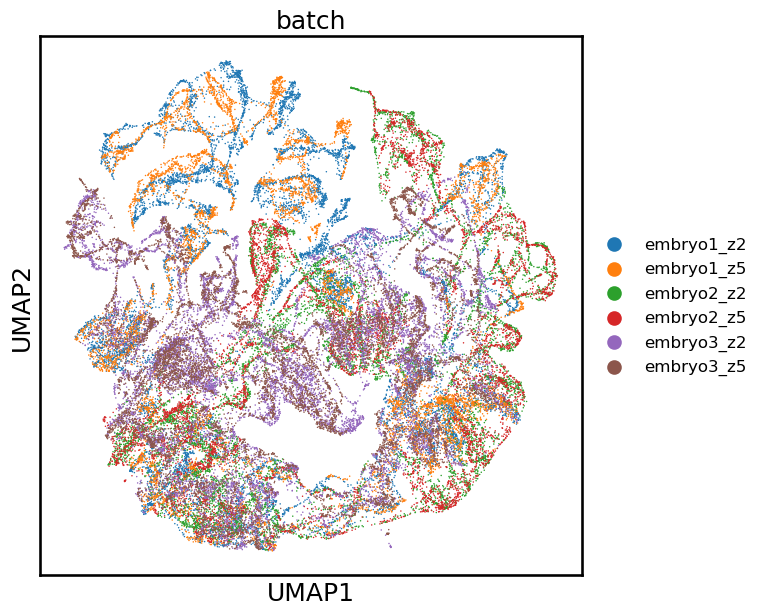

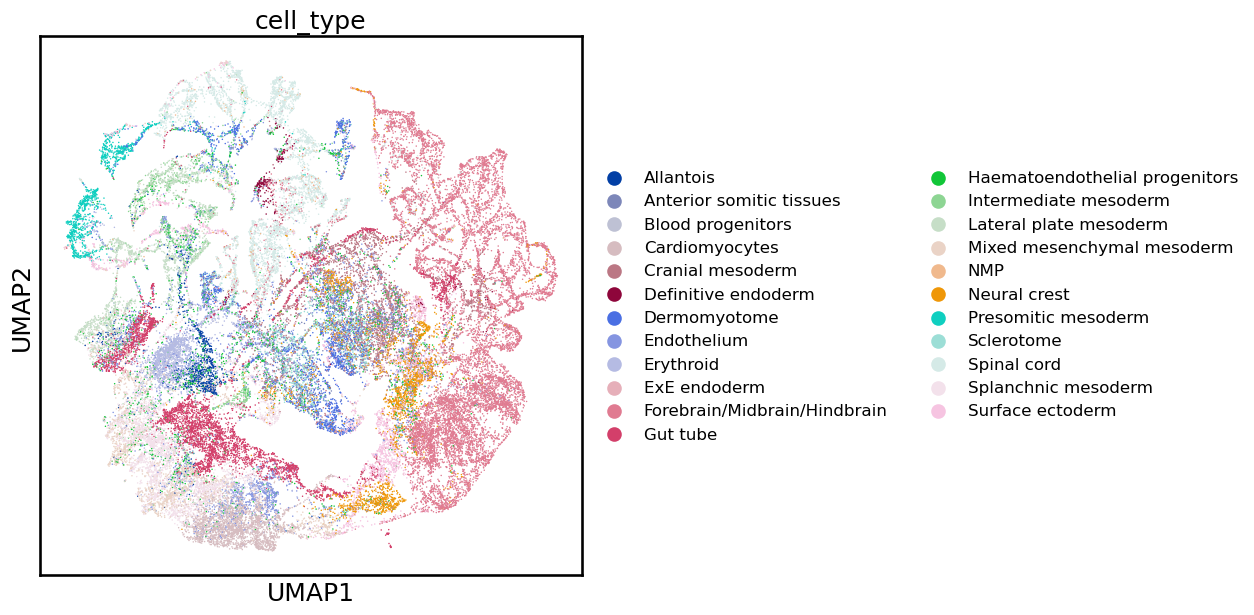

In [411]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run{run_number}")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

# Autotalker
metrics_dict

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run{run_number}")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
1 / (2 * 2 * 2)

In [ ]:
512 * 0.125

In [ ]:
# Autotalker
metrics_dict

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
# Autotalker new (2 layers)
metrics_dict

In [ ]:
# Autotalker new
metrics_dict

In [ ]:
# Autotalker old
metrics_dict

In [ ]:
adata_graph = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_graphst_oneshot_integrated.h5ad")
model = "graphst"
adata = adata_graph

In [ ]:
# GraphST
metrics_dict

In [ ]:
# GraphST
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annbbbbotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
adata_scvi = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_scvi_oneshot_integrated.h5ad")
model = "scvi"
adata = adata_scvi

In [ ]:
# scVI
metrics_dict

In [ ]:
# scVI
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annbbbbotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
adata.obsp["autotalker_latent_run1_connectivities"].sum(axis=1)

In [ ]:
sc.pp.neighbors(adata=adata,
                # use_rep=spatial_key,
                n_neighbors=15,
                random_state=0,
                key_added="spatial",
                knn=True)

In [ ]:
adata.obsp["spatial_connectivities"].toarray()[:10, :200]

In [ ]:
batches = adata.obs[condition_key].unique().tolist()[:7]

In [ ]:
adata_batch_list = []
for batch in batches:
    adata_batch_list.append(adata[adata.obs[condition_key] == batch][:50, :].copy())
adata = sc.concat(adata_batch_list, join="inner")

adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [ ]:
adata

In [ ]:
adata_sample = adata[:5, :]

In [ ]:
adata_sample = adata_batch_list[0].copy()

In [ ]:
adata_sample.obsp["spatial_connectivities"].toarray()

In [ ]:
import squidpy as sq
sq.gr.nhood_enrichment(adata=adata_sample,
                       cluster_key="cell_type",
                       connectivity_key="spatial",
                       n_perms=1000,
                       seed=0,
                       show_progress_bar=False)

In [ ]:
# Compute metrics
metrics_dict = {}

# Spatial conservation metrics
metrics_dict["cas"] = compute_cas(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")
"""
metrics_dict["clisis"] = compute_clisis(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")

# Batch correction metrics
metrics_dict["asw"] = scib.me.silhouette_batch(
    adata=adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=f"{model.lower()}_{latent_key}_run1")
metrics_dict["ilisi"] = scib.me.ilisi_graph(
    adata=adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=f"{model.lower()}_{latent_key}_run1")
    #type_="knn")
"""